Reading Images...
Merging Images...


/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/ipykernel/__main__.py:85: RuntimeWarning: invalid value encountered in true_divide


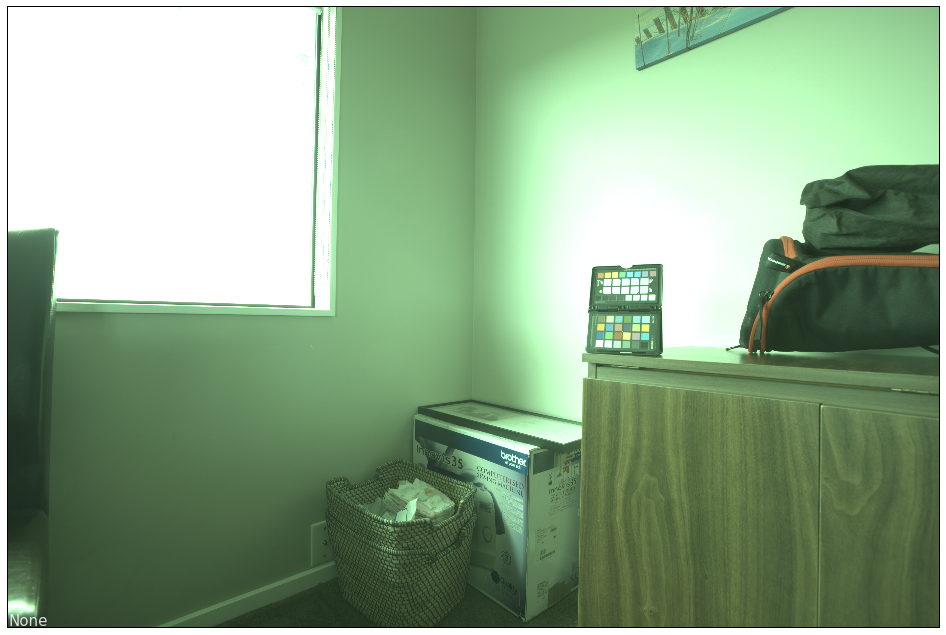

In [1]:
% matplotlib inline

from __future__ import division

import glob
import numpy as np
from collections import namedtuple
from fractions import Fraction

import colour
from colour.plotting import *

from colour_hdri.exif import get_exif_data

ExifData = namedtuple('ExifData', ('aperture', 'shutter_speed', 'iso'))

Image = namedtuple('Image', ('path', 'data', 'exif_data'))


def exposure_value(aperture, shutter_speed, iso):
    N = np.asarray(aperture)
    t = np.asarray(shutter_speed)
    S = np.asarray(iso)

    EV = np.log2(N ** 2) + np.log2(1 / t) - np.log2(100 / S)

    return EV


def average_luminance(aperture, shutter_speed, iso, k=12.5):
    N = np.asarray(aperture)
    t = np.asarray(shutter_speed)
    S = np.asarray(iso)

    L = (S * t) / (k * N ** 2)

    return L


def normal_distribution_function(a, mu=0.5, sigma=0.15):
    a = np.asarray(a)

    return (np.exp(-np.power(a - mu, 2.) /
                   (2 * np.power(sigma, 2.))))


def hat_function(a, sigma=12):
    a = np.asarray(a)

    return 1 - (2 * a - 1) ** sigma


def weighting_function_Debevec97(a):
    a = np.asarray(a)

    min_z = 0.01
    max_z = 0.99
    center = (min_z + max_z) / 2
    mask = np.where(a <= center, True, False)
    weight = np.zeros(a.shape)
    weight[mask] = a[mask] - min_z
    weight[~mask] = max_z - a[~mask]
    weight[weight < 0] = 0
    weight = weight / np.max(weight)

    return weight


def merge_to_hdri(images,
                  weighting_function=weighting_function_Debevec97):
    image_c = None
    weight_c = None
    for _path, image, exif_data in images:
        if image_c is None:
            image_c = np.zeros(image.shape)
            weight_c = np.zeros(image.shape)

        L = average_luminance(exif_data.aperture,
                              exif_data.shutter_speed,
                              exif_data.iso)

        weight = weighting_function(image)

        image_c += weight * image / L
        weight_c += weight

    image_c /= weight_c

    image_c[np.isnan(image_c)] = 0

    return image_c


def process1():
    directory = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/Canon EOS 5D Mark II/Frobisher_002/'
    dng_files = glob.glob('{0}/*.dng'.format(directory))

    OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

    print('Reading Images...')
    images = []
    for dng_file in dng_files:
        exif_data = get_exif_data(dng_file)
        aperture = float(exif_data['EXIF']['Aperture Value'][0])
        shutter_speed = float(Fraction(
            exif_data['EXIF']['Shutter Speed Value'][0]))
        iso = float(exif_data['EXIF']['ISO'][0])

        images.append(Image(dng_file,
                            colour.read_image(dng_file.replace('dng', 'tiff')),
                            ExifData(aperture, shutter_speed, iso)))

    print('Merging Images...')
    image = merge_to_hdri(images)

    image_plot(OECF(image))

    colour.write_image(image, '{0}/Merge.exr'.format(directory))


process1()

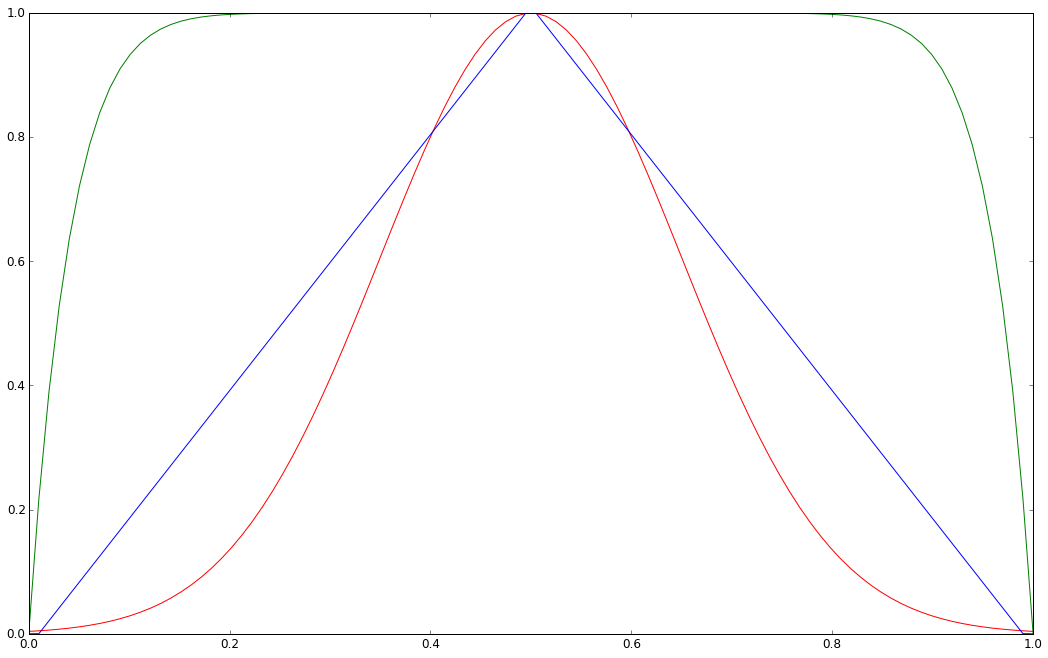

In [2]:
import pylab
    
pylab.plot(np.linspace(0, 1, 100), normal_distribution_function(np.linspace(0, 1, 100)))
pylab.plot(np.linspace(0, 1, 100), hat_function(np.linspace(0, 1, 100)))
pylab.plot(np.linspace(0, 1, 100), weighting_function_Debevec97(np.linspace(0, 1, 100)))
pylab.show()